# Calcium Detection - Fluorescence values
Guy Teichman & Moran Neuhof

## Introduction
This appendix is dedicated to plotting the values and behavior of cell fluorescence, in the data we received.
In addition to the methods applied for neuron detection, we present how the behavior of individual neurons looks over time, based on their recorded fluorescence values.

In [1]:
# importing project code
from Segmentation.params import *
from Segmentation.processing_funcs import *
from Segmentation.kmeans import *
from Segmentation.evaluate import *
from Segmentation.utilities import *
from Segmentation.cellFluor import *

%matplotlib inline

## Loading Calcium Imaging Data

C:\Users\t-moneuh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


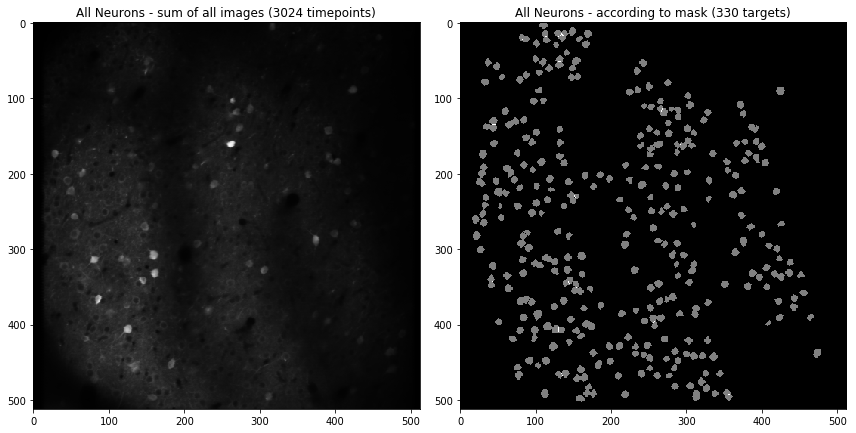

In [2]:
# load the images
files = sorted(glob(imgs_path))
imgs = np.array([imread(f) for f in files])
dims = imgs.shape[1:]

# Loading masks
masks = plotregions(regions_file, dims)
summed = np.float64(imgs.sum(axis=0))
imgf = np.concatenate((imgs[0:2060,:,:], imgs[2250:,:,:]), axis=0)  # removed artifact
summedf = np.float64(imgf.sum(axis=0))

# show the outputs
plt.subplots(1,2, figsize=(12,12))
plt.subplot(1, 2, 1)
plt.imshow(summedf, cmap='gray')
plt.title(f'All Neurons - sum of all images ({len(imgs)} timepoints)')
plt.subplot(1, 2, 2)
plt.imshow(masks.sum(axis=0), cmap='gray')
plt.title(f'All Neurons - according to mask ({len(masks)} targets)')
plt.tight_layout()

In [31]:
def plotCellFluorescence(imgs, filename, sampling_frequency=7, figsize=(12,12), neuron_lim=None): 
    """Receive the images and coordinated filename, and plots the fluorescence over time. 
    Optional arguments:
    sampling_frequency: In our case, it's 7 Hz
    neuon_lim: a tuple of the range of neuorns (out of the whole dataset) to plot. If None, plot all."""
    with open(filename+'.json') as f:   # read the json file again
        regions = json.load(f)
    
    dims = imgs.shape[1:]
    cells = np.array([tomask(s['coordinates'], dims) for s in regions])  # regions
    activity = np.zeros([np.shape(cells)[0], np.shape(imgs)[0]])  # initialize timeseries
    # activity (cell x timepoints) - measure activity for each cell (cell) for each timepoint (img, n)
    
    for cell, cellCoord in enumerate(cells):  # for each cell
        p = len(cellCoord) # number of pixels in ROI
        Ft = np.sum(imgs[:,cellCoord],axis=1) / p # value of all pixels divided by number of pixels
        #Fxsmoothed=0 # calculate Fx smoothed
        F0 = np.percentile(Ft,10) #calculate F0  # normalized to 10th percentile
        Rt = (Ft-F0) / F0
        activity[cell,:] = Rt
        # sum of all flourescence values in the cell coordinates - for each of the timepoints
    
    plt.figure(figsize=figsize)
    for cell in range(np.shape(cells)[0]):
        plt.plot(np.linspace(0, np.shape(imgs)[0] / sampling_frequency, np.shape(imgs)[0]), activity[cell,:] + cell)  
    plt.title("Fluorescence of recognized cells")
    plt.xlabel("$t$ [s]")
    plt.ylabel("Cell ID")
    if neuron_lim:
        min_neuron, max_neuron = neuron_lim
        plt.ylim(min_neuron, max_neuron)  # limit to only a certain amount of neurons
    sns.despine()
    return activity

In the above `plotCellFluorescence`, we plot the values for each neuron, normalized according to its basal activity ($F0$). The basal activity of the neuron is defined as the 10th percentile value of its fluorescense (over time).  

### Naive plotting
Shown are the regions provided as ground truth.

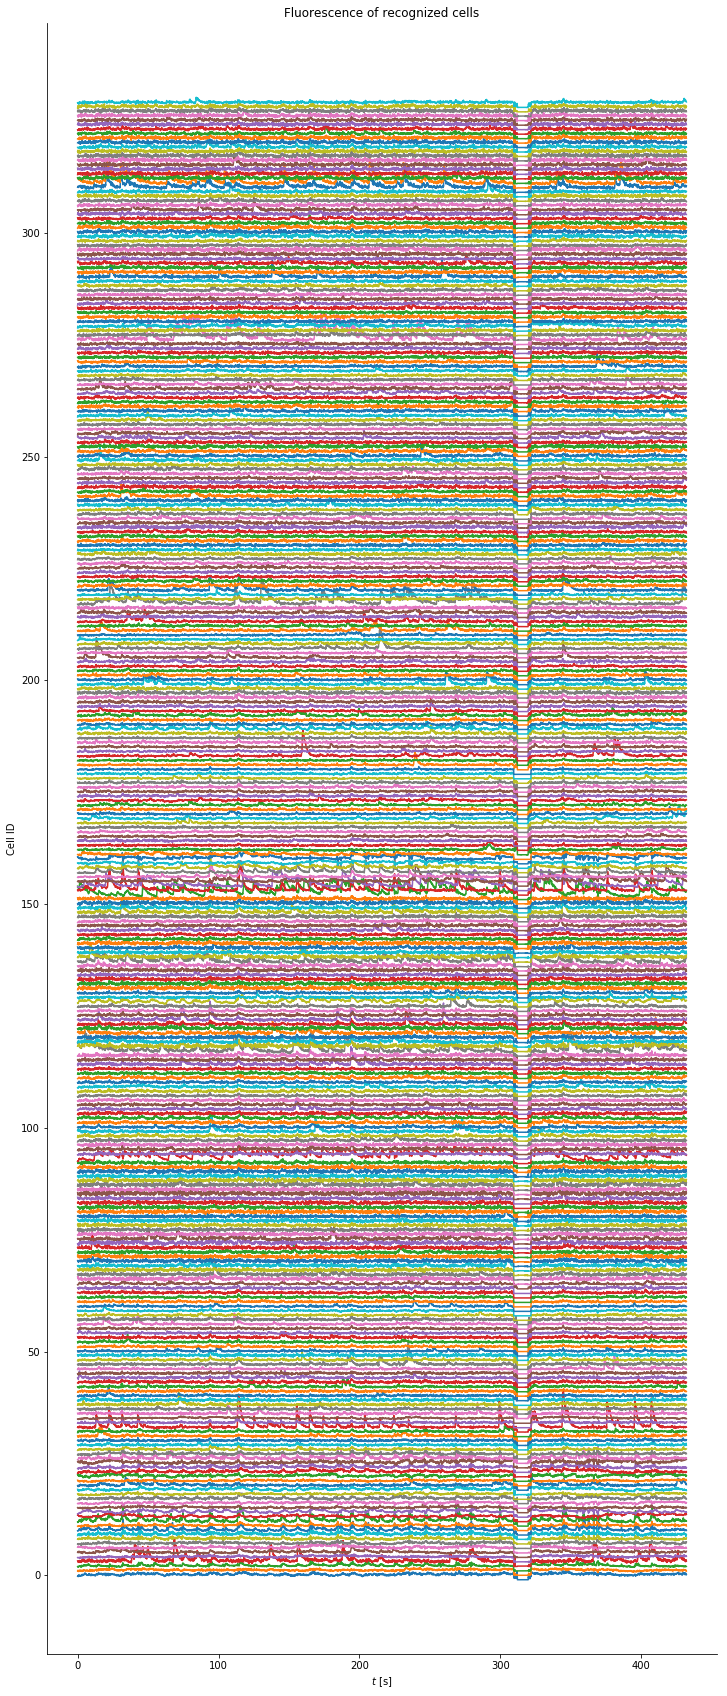

In [33]:
# plot fluorescence
activity = plotCellFluorescence(imgs, regions_file, figsize=(12,30))

When looking at a smaller subset of these neurons, the results are easier to understand.

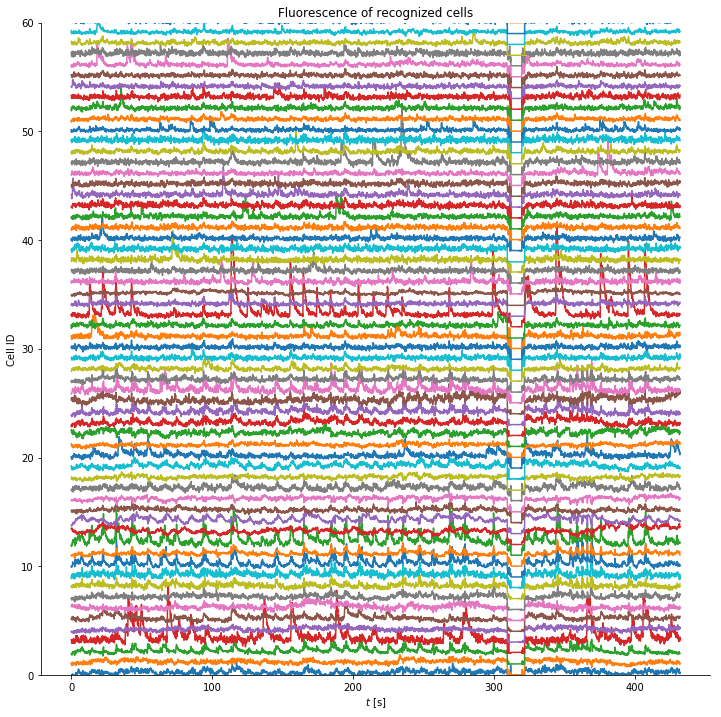

In [27]:
# plot fluorescence
activity = plotCellFluorescence(imgs, regions_file, neuron_lim=(0,60))

#### Removing technical artifact
We can clearly see an artifact around the time of 310-340 seconds. We removed this artifact for further analysis.

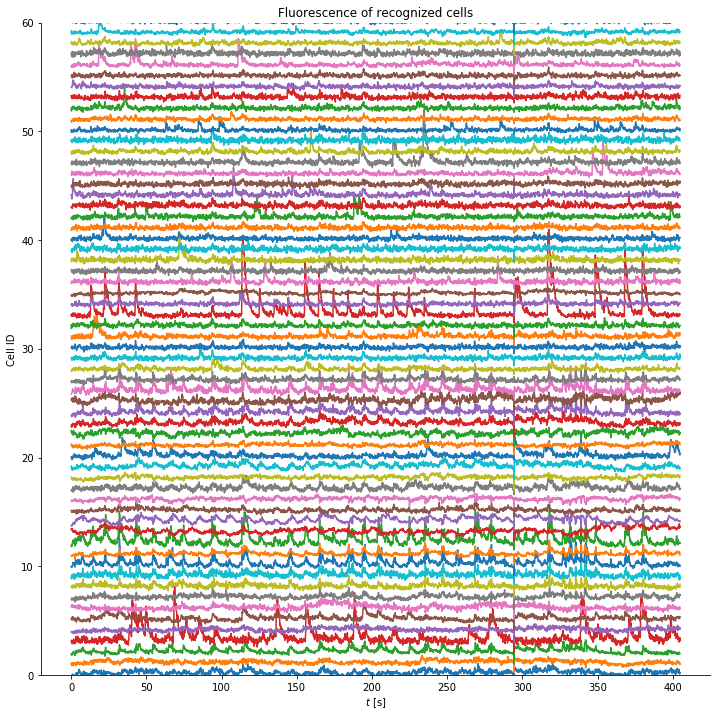

In [28]:
imgf = np.concatenate((imgs[0:2060,:,:], imgs[2250:,:,:]), axis=0)  # removed artifact
# plot fluorescence
activity = plotCellFluorescence(imgf, regions_file, neuron_lim=(0,60))

#### Smoothing using gaussian filter
We then used gaussian filter over time for smoothing, as discussed in the main text.

In [6]:
# Creating a list of filters and their parameters
filter_methods = [(ndimage.gaussian_filter1d, 4)]
# Filtering each pixel's change in fluorescence over time
ts_filtered_imgs = filter_timeseries(np.float64(imgf), filter_methods)

Running 1 timelapse filtering methods.


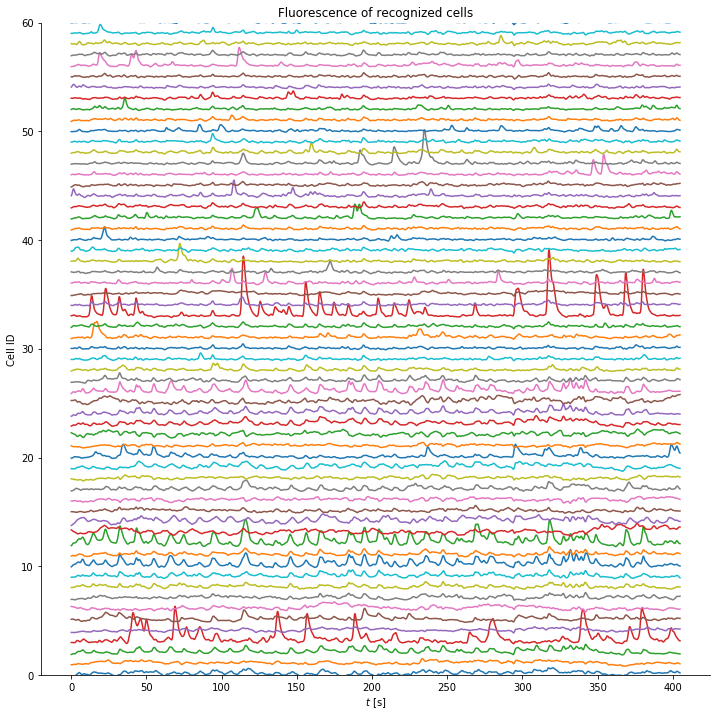

In [29]:
# plot fluorescence
activity = plotCellFluorescence(ts_filtered_imgs[0][0], regions_file,  neuron_lim=(0,60))

### Plotting the results achieved by our pipeline on the same dataset

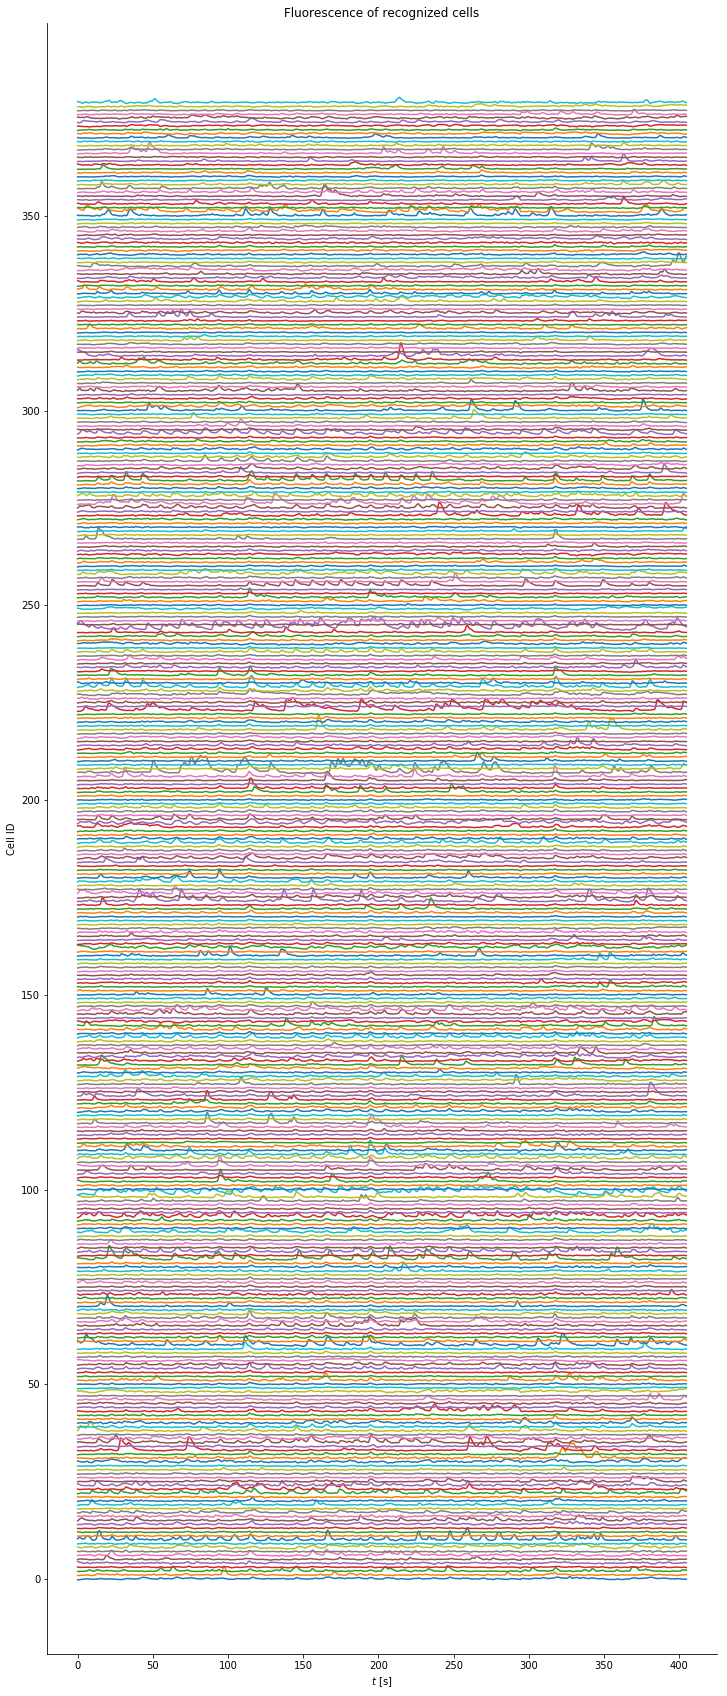

In [32]:
# plot fluorescence
activity = plotCellFluorescence(ts_filtered_imgs[0][0], 'pipeline1', figsize=(12,30), neuron_lim=None)

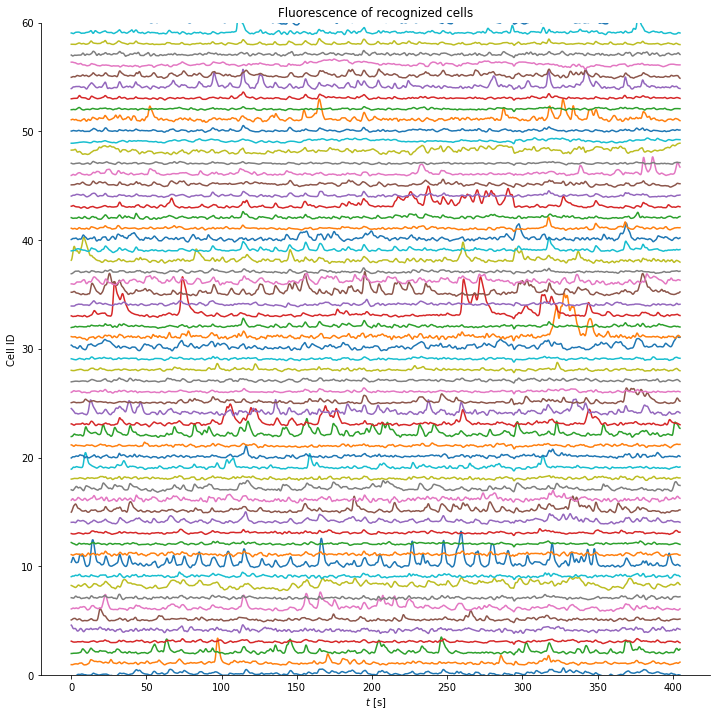

In [30]:
# plot fluorescence
activity = plotCellFluorescence(ts_filtered_imgs[0][0], 'pipeline1', neuron_lim=(0,60))